## Pós graduação em inteligência artificial aplicada

### Alunos: Guilherme Oishi Feitosa e Renan Moraes
### Orientador: Johannes 

<h1 align="center"> Tema: Detecção de solonência usando deep learning </h1>

### Introdução ao problema

O problema abordado nesse trabalho será a detecção de sonolência já que esta está diretamente relacionada a diversos tipos de acidentes principalmente acidentes de trânsito.

A sonolência é uma das grandes causadores de acidentes, principalmente acidentes de trânsito, segundo uma pesquisa realizada pela Associação Brasileira de Medicina de Tráfego (ABRAMET) em parceria com a Academia Brasileira de Neurologia e o Conselho Regional de Medicina indicou que cerca de 42% dos acidentes de trânsito estão relacionados ao sono (https://autopapo.uol.com.br/noticia/mais-de-40-dos-acidentes-de-transito-acontece-por-sonolencia-afirma-a-abramet/).

Segundo pesquisas dirigir com sono pode ser tão perigoso quanto dirigir alcoolizado (BATISTA, 2017). 

<img src="acidente_sono.jpg" width="500">

Com isso, acredita-se que se houver uma maneira de identificar e alertar o motorista no momento da sonolência, grande parte desses acidentes possam ser evitados.  

### Importando bibliotecas necessárias

In [72]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet_v2 import ResNet50V2
from keras.applications.xception import Xception
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

### Imagens utilizadas para treinar/testar os modelos

##### Para treinar o modelo foram utilizadas duas categorias de imagens
- Pessoas com os olhos abertos
- Pessoas com os olhos fechados

As imagens de pessoas com olhos abertos foram obtidas no link: https://cswww.essex.ac.uk/mv/allfaces/

Neste link há quatro datasets com fotos de faces de pessoas, a única diferente entre elas é o fundo da imagem, porém como este será removido posteriormente, foram utilizadas duas amostras de cada individuo dos datasets, apenas algumas imagens que apresentavam uma baixa qualidade não foram aproveitadas.

As imagens de pessoas com olhos fechados foram obtidas no link: http://parnec.nuaa.edu.cn/_upload/tpl/02/db/731/template731/pages/xtan/ClosedEyeDatabases.html

Neste link há um dataset contendo diversas imagens de pessoas com olhos fechados, porém esse dataset está um pouco bagunçado com algumas imagens de pessoas com olhos abertos, então foi necessária uma limpeza, foram removidos esses casos e também foram removidas fotos de crianças e algumas fotos que apresentavam baixa qualidade.

Além dos link apresentados acima, também foram utilizadas algumas fotos dos autores e de alguns amigos

### Definindo função que dado um diretório aplica uma segmentação de face em todas as imagens

In [59]:
def Corta_Face (diretorio, label):
    
    index = 1
    
    # Carregando o modelo de detecção
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

    # Iternado sobre todas as imagens da pasta
    for filename in os.listdir(diretorio):

        # Considerando apenas imagens com extensão .jpg
        if filename.endswith(".jpg"):

            # Mudando o diretório
            os.chdir(diretorio)

            # Lendo a imagem
            img = cv2.imread(filename, cv2.IMREAD_COLOR)

            # Convertendo em escala de cinza
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

            # Detectando o rosto
            faces = face_cascade.detectMultiScale(gray, 1.1, 2)

            if len(faces) != 0: 
                # Cortando o fundo da imagem, deixando apenas a região de interesse
                for (x, y, w, h) in faces:
                    face_crop = img[y:y+h, x:x+w]

                # Definindo nome da nova imagem
                new_filename = label + '_' + str(index) + '.jpg'

                # Ajustando a imagem para 100 x 100
                face_crop = cv2.resize(face_crop, (100, 100))

                # Salvando a imagem cortada
                cv2.imwrite(new_filename, face_crop)    

                # Removendo a imagem original da pasta
                os.remove(filename)

                index = index + 1

            else:
                # Removendo a imagem original da pasta
                os.remove(filename)

        else:
            continue

### Aplicando função corta face nas fotos de olho fechado

In [6]:
# Definindo diretório que será aplicado
directory = r'C:\Users\R\Desktop\TCC- Pós\Fotos\Fotos olho fechado'

Corta_Face(directory, "olho_fechado")

### Aplicando função corta face nas fotos de olho aberto

In [9]:
# Definindo diretório que será aplicado
directory = r'C:\Users\R\Desktop\TCC- Pós\Fotos\Fotos olho aberto'

Corta_Face(directory, "olho_aberto")

### Caregando os dados de treino

In [3]:
img_width, img_height = 100, 100

In [32]:
train_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory('Fotos_variadas/train/', 
                                                    target_size=(img_width, img_height),
                                                    class_mode='categorical',
                                                    color_mode='rgb',
                                                    batch_size=32,
                                                    shuffle=True)

Found 851 images belonging to 2 classes.


In [94]:
train_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [33]:
test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory('Fotos_variadas/test/', 
                                                  target_size=(img_width, img_height),
                                                  class_mode='categorical', 
                                                  color_mode='rgb',
                                                  batch_size=32,
                                                  shuffle=True,)

Found 358 images belonging to 2 classes.


In [34]:
# Carrega o modelo sem as camadas de classificação
resnet_model = ResNet50(include_top=False, weights="imagenet", input_shape=(100, 100, 3))
#resnet_model = ResNet50(include_top=False, input_shape=(100, 100, 3))

# Define as camadas em que não será feito o treinamento
for layer in resnet_model.layers:
  layer.trainable = False
   
resnet_model.summary()

model = Sequential([
    resnet_model,
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(2, activation='softmax')
])

model.summary()

C:\Users\R\Anaconda3\envs\cvision\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 106, 106, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 50, 50, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 50, 50, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 4, 4, 2048)        23587712  
_________________________________________________________________
flatten_5 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 1024)              33555456  
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 2050      
Total params: 57,145,218
Trainable params: 33,557,506
Non-trainable params: 23,587,712
_________________________________________________________________


In [35]:
earlystopper = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=15, 
    mode='min', 
    verbose=1)

In [36]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.3, 
    patience=5, 
    min_lr=0, 
    verbose=1)

In [37]:
model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [39]:
EPOCHS = 20

hist = model.fit_generator(
    train_generator,
    steps_per_epoch=np.ceil(851/32),
    epochs=EPOCHS,
    validation_data=test_generator,
    validation_steps=np.ceil(358/32),
    callbacks=[earlystopper, reduce_lr]
)

Epoch 1/20
27/27 [==============================] - 172s 6s/step - loss: 1.5763 - accuracy: 0.9025 - val_loss: 1.1921e-07 - val_accuracy: 0.8966
Epoch 2/20
27/27 [==============================] - 177s 7s/step - loss: 1.5603 - accuracy: 0.9001 - val_loss: 5.3727 - val_accuracy: 0.6648
Epoch 3/20
27/27 [==============================] - 174s 6s/step - loss: 1.2853 - accuracy: 0.9189 - val_loss: 8.0590 - val_accuracy: 0.4972
Epoch 4/20
27/27 [==============================] - 175s 6s/step - loss: 1.0382 - accuracy: 0.9342 - val_loss: 5.3727 - val_accuracy: 0.4860
Epoch 5/20
27/27 [==============================] - 170s 6s/step - loss: 1.0827 - accuracy: 0.9307 - val_loss: 1.1921e-07 - val_accuracy: 0.9330
Epoch 6/20
27/27 [==============================] - 170s 6s/step - loss: 1.3872 - accuracy: 0.9142 - val_loss: 2.6863 - val_accuracy: 0.8827

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.
Epoch 7/20
27/27 [==============================] - 169s 6s/step 

In [40]:
model.save("resnet_imagenet")

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10))
ax1.plot(hist.history['loss'], color='b', label='Training loss')
ax1.plot(hist.history['val_loss'], color='r', label='Validation loss')
ax1.set_xticks(np.arange(1, EPOCHS, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(hist.history['accuracy'], color='b', label='Training accuracy')
ax2.plot(hist.history['val_accuracy'], color='r', label='Validation accuracy')
ax2.set_xticks(np.arange(1, EPOCHS, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [ ]:
scores = model.evaluate_generator(generator=test_generator,
steps=np.ceil(364/64))

print("Accuracy = ", scores[1])

In [41]:
# Carrega o modelo sem as camadas de classificação
xception = Xception(include_top=False, weights="imagenet", input_shape=(100, 100, 3))
#resnet_model = ResNet50(include_top=False, input_shape=(100, 100, 3))

# Define as camadas em que não será feito o treinamento
for layer in xception.layers:
  layer.trainable = False
   
xception.summary()

xception_model = Sequential([
    xception,
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(2, activation='softmax')
])

xception_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 49, 49, 32)   864         input_6[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 49, 49, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 49, 49, 32)   0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 3, 3, 2048)        20861480  
_________________________________________________________________
flatten_6 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 1024)              18875392  
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 2050      
Total params: 39,738,922
Trainable params: 18,877,442
Non-trainable params: 20,861,480
_________________________________________________________________


In [42]:
xception_model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [43]:
EPOCHS = 20

hist = xception_model.fit_generator(
    train_generator,
    steps_per_epoch=np.ceil(851/32),
    epochs=EPOCHS,
    validation_data=test_generator,
    validation_steps=np.ceil(358/32),
    callbacks=[earlystopper, reduce_lr]
)

Epoch 1/20
27/27 [==============================] - 141s 5s/step - loss: 1.8795 - accuracy: 0.7638 - val_loss: 8.0590 - val_accuracy: 0.4860
Epoch 2/20
27/27 [==============================] - 142s 5s/step - loss: 0.5790 - accuracy: 0.9001 - val_loss: 10.7454 - val_accuracy: 0.4832
Epoch 3/20
27/27 [==============================] - 138s 5s/step - loss: 0.5871 - accuracy: 0.9001 - val_loss: 10.7454 - val_accuracy: 0.4860
Epoch 4/20
27/27 [==============================] - 138s 5s/step - loss: 0.4400 - accuracy: 0.9236 - val_loss: 8.0590 - val_accuracy: 0.4609
Epoch 5/20
27/27 [==============================] - 138s 5s/step - loss: 0.2529 - accuracy: 0.9412 - val_loss: 10.7454 - val_accuracy: 0.4385
Epoch 6/20
27/27 [==============================] - 139s 5s/step - loss: 0.4713 - accuracy: 0.9389 - val_loss: 11.2188 - val_accuracy: 0.5196

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.
Epoch 7/20
27/27 [==============================] - 138s 5s/step - lo

In [44]:
xception_model.save("xception_imagenet")

In [45]:
# Carrega o modelo sem as camadas de classificação
vgg16 = VGG16(include_top=False, weights="imagenet", input_shape=(100, 100, 3))
#resnet_model = ResNet50(include_top=False, input_shape=(100, 100, 3))

# Define as camadas em que não será feito o treinamento
for layer in vgg16.layers:
  layer.trainable = False
   
vgg16.summary()

vgg16_model = Sequential([
    vgg16,
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(2, activation='softmax')
])

vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

In [46]:
vgg16_model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [47]:
EPOCHS = 20

hist = vgg16_model.fit_generator(
    train_generator,
    steps_per_epoch=np.ceil(851/32),
    epochs=EPOCHS,
    validation_data=test_generator,
    validation_steps=np.ceil(358/32),
    callbacks=[earlystopper, reduce_lr]
)

Epoch 1/20
27/27 [==============================] - 148s 5s/step - loss: 2.5881 - accuracy: 0.8120 - val_loss: 2.6863 - val_accuracy: 0.9022
Epoch 2/20
27/27 [==============================] - 150s 6s/step - loss: 1.3254 - accuracy: 0.9142 - val_loss: 1.1921e-07 - val_accuracy: 0.9497
Epoch 3/20
27/27 [==============================] - 153s 6s/step - loss: 1.1336 - accuracy: 0.9295 - val_loss: 1.1921e-07 - val_accuracy: 0.9469
Epoch 4/20
27/27 [==============================] - 149s 6s/step - loss: 1.2896 - accuracy: 0.9166 - val_loss: 1.1921e-07 - val_accuracy: 0.9497
Epoch 5/20
27/27 [==============================] - 150s 6s/step - loss: 1.1135 - accuracy: 0.9283 - val_loss: 2.6863 - val_accuracy: 0.9553
Epoch 6/20
27/27 [==============================] - 150s 6s/step - loss: 1.7962 - accuracy: 0.8884 - val_loss: 8.0590 - val_accuracy: 0.6676
Epoch 7/20
27/27 [==============================] - 151s 6s/step - loss: 3.1841 - accuracy: 0.8026 - val_loss: 1.1921e-07 - val_accuracy: 0.91

In [48]:
vgg16_model.save("vgg16_imagenet")

In [49]:
# Carrega o modelo sem as camadas de classificação
inception_v3 = InceptionV3(include_top=False, weights="imagenet", input_shape=(100, 100, 3))
#resnet_model = ResNet50(include_top=False, input_shape=(100, 100, 3))

# Define as camadas em que não será feito o treinamento
for layer in inception_v3.layers:
  layer.trainable = False
   
inception_v3.summary()

inception_v3_model = Sequential([
    inception_v3,
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(2, activation='softmax')
])

inception_v3_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
conv2d_103 (Conv2D)             (None, 49, 49, 32)   864         input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_103 (BatchN (None, 49, 49, 32)   96          conv2d_103[0][0]                 
__________________________________________________________________________________________________
activation_144 (Activation)     (None, 49, 49, 32)   0           batch_normalization_103[0][0]    
_______________________________________________________________________________________

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 1, 1, 2048)        21802784  
_________________________________________________________________
flatten_8 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dense_16 (Dense)             (None, 2)                 2050      
Total params: 23,903,010
Trainable params: 2,100,226
Non-trainable params: 21,802,784
_________________________________________________________________


In [50]:
inception_v3_model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [51]:
EPOCHS = 20

hist = inception_v3_model.fit_generator(
    train_generator,
    steps_per_epoch=np.ceil(851/32),
    epochs=EPOCHS,
    validation_data=test_generator,
    validation_steps=np.ceil(358/32),
    callbacks=[earlystopper, reduce_lr]
)

Epoch 1/20
27/27 [==============================] - 50s 2s/step - loss: 0.8538 - accuracy: 0.5899 - val_loss: 2.6863 - val_accuracy: 0.6480
Epoch 2/20
27/27 [==============================] - 47s 2s/step - loss: 0.5097 - accuracy: 0.7532 - val_loss: 1.1921e-07 - val_accuracy: 0.7682
Epoch 3/20
27/27 [==============================] - 48s 2s/step - loss: 0.4819 - accuracy: 0.7885 - val_loss: 5.6306 - val_accuracy: 0.7179
Epoch 4/20
27/27 [==============================] - 48s 2s/step - loss: 0.4618 - accuracy: 0.7756 - val_loss: 8.0594 - val_accuracy: 0.8045
Epoch 5/20
27/27 [==============================] - 49s 2s/step - loss: 0.3813 - accuracy: 0.8273 - val_loss: 8.0590 - val_accuracy: 0.5810
Epoch 6/20
27/27 [==============================] - 48s 2s/step - loss: 0.3902 - accuracy: 0.8378 - val_loss: 5.3727 - val_accuracy: 0.5168
Epoch 7/20
27/27 [==============================] - 48s 2s/step - loss: 0.3981 - accuracy: 0.8249 - val_loss: 2.6863 - val_accuracy: 0.8073

Epoch 00007: Re

In [52]:
inception_v3_model.save("inception_v3_imagenet")

In [53]:
# Carrega o modelo sem as camadas de classificação
resenet_v2 = ResNet50V2(include_top=False, weights="imagenet", input_shape=(100, 100, 3))
#resnet_model = ResNet50(include_top=False, input_shape=(100, 100, 3))

# Define as camadas em que não será feito o treinamento
for layer in resenet_v2.layers:
  layer.trainable = False
   
resenet_v2.summary()

resenet_v2_model = Sequential([
    resenet_v2,
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(2, activation='softmax')
])

resenet_v2_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 106, 106, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 50, 50, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 52, 52, 64)   0           conv1_conv[0][0]                 
_________________________________________________________________________________________

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 4, 4, 2048)        23564800  
_________________________________________________________________
flatten_9 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_17 (Dense)             (None, 1024)              33555456  
_________________________________________________________________
dense_18 (Dense)             (None, 2)                 2050      
Total params: 57,122,306
Trainable params: 33,557,506
Non-trainable params: 23,564,800
_________________________________________________________________


In [54]:
resenet_v2_model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [55]:
EPOCHS = 20

hist = resenet_v2_model.fit_generator(
    train_generator,
    steps_per_epoch=np.ceil(851/32),
    epochs=EPOCHS,
    validation_data=test_generator,
    validation_steps=np.ceil(358/32),
    callbacks=[earlystopper, reduce_lr]
)

Epoch 1/20
27/27 [==============================] - 144s 5s/step - loss: 1.6182 - accuracy: 0.8707 - val_loss: 13.4317 - val_accuracy: 0.5140
Epoch 2/20
27/27 [==============================] - 137s 5s/step - loss: 1.0069 - accuracy: 0.9271 - val_loss: 5.3727 - val_accuracy: 0.5196
Epoch 3/20
27/27 [==============================] - 137s 5s/step - loss: 1.0706 - accuracy: 0.9330 - val_loss: 2.6863 - val_accuracy: 0.5140
Epoch 4/20
27/27 [==============================] - 139s 5s/step - loss: 1.1781 - accuracy: 0.9224 - val_loss: 5.3727 - val_accuracy: 0.5140
Epoch 5/20
27/27 [==============================] - 137s 5s/step - loss: 1.1367 - accuracy: 0.9260 - val_loss: 5.3727 - val_accuracy: 0.5140
Epoch 6/20
27/27 [==============================] - 138s 5s/step - loss: 1.1639 - accuracy: 0.9248 - val_loss: 5.3727 - val_accuracy: 0.5140
Epoch 7/20
27/27 [==============================] - 137s 5s/step - loss: 1.1403 - accuracy: 0.9271 - val_loss: 10.7454 - val_accuracy: 0.5140
Epoch 8/20


In [56]:
resenet_v2_model.save("resenet_v2_imagenet")

### Fazendo predição 

In [62]:
# Definindo diretório que será aplicado
directory = r'C:\Users\R\Desktop\TCC- Pós\predict'

Corta_Face(directory, "predict")

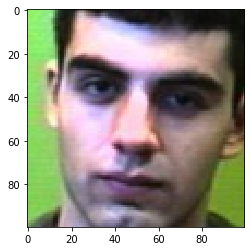

In [142]:
# Carrega a imagem
image_original = load_img('predict/predict_4.jpg', target_size=(100, 100))
plt.imshow(image_original);plt.show()

In [143]:
# Converte a imagem em um array
image = img_to_array(image_original)

# Redimensiona a imagem para o modelo
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

# Prepara a imagem de entrada para o VGG16
#image = preprocess_input(image)

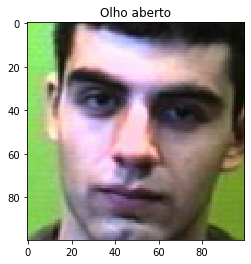

In [144]:
# Prediz a probabilidade dentre todas as classes
pred = vgg16_model.predict(image)

if pred[0][0] == 1:
    plt.imshow(image_original);plt.title('Olho aberto');plt.show()   
else:
    plt.imshow(image_original);plt.title('Olho fechado');plt.show()  

### Data Augumentation

In [ ]:
train_datagen = ImageDataGenerator(rotation_range=7.5,
                                   shear_range=0.1,
                                    zoom_range=0.2,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    rescale=1./255))

train_generator = train_datagen.flow_from_directory('Fotos/train/', 
                                                    target_size=(img_width, img_height),
                                                    class_mode='categorical',
                                                    color_mode='rgb',
                                                    batch_size=64)    
